Install necessary Packages

In [ ]:
pip install pycox auton_survival

Import required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import torch  
import torchtuples as tt 
from matplotlib import pyplot as plt

In [1]:
# Read the dataset

data = pd. read_csv('bpic.csv')

Data Pre-Processing

In [2]:

data.rename(columns={'Unnamed: 0': 'Case ID', 'time:timestamp' : 'Complete Timestamp', 'concept:name': 'Activity', 'case:ApplicationType' : 'ApplicationType',  'case:LoanGoal': 'LoanGoal', 'case:RequestedAmount' : 'RequestedAmount', 'org:resource': 'user' }, inplace=True)

In [3]:
#Format for deephit. lable=1 => event happens, label=0=> event doesn't happen

data.loc[:, 'label'] = 1

In [4]:
data.drop(columns=['EventID','OfferID'], inplace=True)

In [6]:
data.head()

,Case ID,Action,user,Activity,EventOrigin,lifecycle:transition,Complete Timestamp,LoanGoal,ApplicationType,case:concept:name,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,label
0,0,Created,User_1,A_Create Application,Application,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,statechange,User_1,A_Submitted,Application,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,Created,User_1,W_Handle leads,Workflow,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,Deleted,User_1,W_Handle leads,Workflow,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,Created,User_1,W_Complete application,Workflow,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [7]:
# Sort the data by "application_id" and "timestamp" in increasing order
data = data.sort_values(by=["case:concept:name", "Complete Timestamp"])


In [8]:
# Re-arrange dataframe

temp_col = data['case:concept:name']

data.drop(columns=['case:concept:name'], inplace=True)

data.insert(1, 'case:concept:name', temp_col)

In [9]:
data.head()

,Case ID,case:concept:name,Action,user,Activity,EventOrigin,lifecycle:transition,Complete Timestamp,LoanGoal,ApplicationType,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,label
686058,686058,Application_1000086665,Created,User_1,A_Create Application,Application,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
686059,686059,Application_1000086665,statechange,User_1,A_Submitted,Application,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
686060,686060,Application_1000086665,Created,User_1,W_Handle leads,Workflow,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
686061,686061,Application_1000086665,Deleted,User_1,W_Handle leads,Workflow,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
686062,686062,Application_1000086665,Created,User_1,W_Complete application,Workflow,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Feature Engineering

In [10]:
#Create a new fetaure 'duration'

data['Complete Timestamp']=pd.to_datetime(data['Complete Timestamp'])

grouped_df = data.groupby('case:concept:name')


# Add a new column with the timestamp of the previous row
data['prev_timestamp'] = grouped_df['Complete Timestamp'].shift(1)

# Calculate the duration by subtracting the previous timestamp from the current timestamp
data['duration'] = data['Complete Timestamp'] - data['prev_timestamp']

data['duration']=data['duration'].dt.total_seconds()


# Drop the temporary column
data.drop(columns=['prev_timestamp'], inplace=True)

data['duration']=data['duration'].fillna(0)

In [11]:
data['duration']

686058         0.000
686059         0.061
686060         0.229
686061        66.323
686062         0.007
             ...    
918295     70493.678
918296       150.855
918297    338550.389
918298         0.003
918299         0.002
Name: duration, Length: 1202267, dtype: float64

In [12]:
cat_feats = ['Action','Activity', 'EventOrigin', 'lifecycle:transition', 'LoanGoal', 'ApplicationType', 'Accepted', 'Selected']       # categorical_features
num_feats = ['RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms', 'MonthlyCost', 'CreditScore', 'OfferedAmount', 'duration']  # numerical_features
cat_int_encoding= ['case:concept:name']                                                                                               # unique identifier(int)

In [13]:
#Fill missing values with 0

null_counts = data.isnull().sum()
null_columns = null_counts[null_counts > 0].index

for i in null_columns:
  if i in num_feats:
    data[i].fillna(0, inplace=True)    

In [15]:
# Enocde the features to numerical representations 


# Now, let's one hot encode the cat_feats
one_hot_encoder = OneHotEncoder()
one_hot_features = one_hot_encoder.fit_transform(data[cat_feats])

# The above line returns a sparse matrix, so we can convert it to a dense numpy array
one_hot_features = one_hot_features.toarray()

# Now, let's integer encode the cat_int_encoding feature
label_encoder = LabelEncoder()
int_feature = label_encoder.fit_transform(data['case:concept:name'])

# Now, let's concatenate the one hot encoded features and the integer encoded feature, along with the numerical features
final_features = np.concatenate((one_hot_features, int_feature.reshape(-1, 1)), axis=1)
final_features = np.concatenate((final_features, data[num_feats].values), axis=1)

# final_features is now a numpy array that contains all of the encoded features


In [16]:
# Create a pandas DataFrame from the array

df_final = pd.DataFrame()

# Next, let's add the one hot encoded features to the DataFrame
one_hot_columns = []
for i, col in enumerate(cat_feats):
    one_hot_columns += [f"{col}_{c}" for c in one_hot_encoder.categories_[i]]
df_final[one_hot_columns] = pd.DataFrame(one_hot_features)

# Now, let's add the integer encoded feature to the DataFrame
df_final['case:concept:name'] = int_feature

# Finally, let's add the numerical features to the DataFrame
df_final[num_feats] = data[num_feats]

# Now, df_final is a DataFrame with the original column names and the encoded features

# Reorder the columns to make 'case:concept:name' the first column
df_final = df_final[['case:concept:name'] + one_hot_columns + num_feats]

# The DataFrame now has 'case:concept:name' as the first column


In [17]:
# The Time duration, 'duration' is our target variable
duration=df_final['duration'].values
df_final.drop('duration', axis=1, inplace=True)

In [18]:
df_final

,case:concept:name,Action_Created,Action_Deleted,Action_Obtained,Action_Released,Action_statechange,Activity_A_Accepted,Activity_A_Cancelled,Activity_A_Complete,Activity_A_Concept,...,Accepted_nan,Selected_False,Selected_True,Selected_nan,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,31508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
1202263,31508,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
1202264,31508,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0
1202265,31508,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,20000.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#This is how the DeepHit format expects the data to be formatted.

label=data['label']

tar=np.column_stack((duration, label))
df_target= pd.DataFrame(data=tar, columns=['duration', 'event'])

In [24]:
#Split the data into train,test and validation gropus

x= df_final
y=df_target
grouped = x.groupby('case:concept:name')

# Initialize empty lists to store the split datasets
x_train_list = []
y_train_list = []
x_val_list = []
y_val_list = []
x_test_list = []
y_test_list = []

# Iterate over the groups
for user, group in grouped:
  # Calculate the number of samples in each set
  n = len(group)
  tr_size = int(n * 0.60)  # 60% for training
  vl_size = int(n * 0.20)  # 20% for validation
  te_size = int(n * 0.20)  # 20% for test

  # Split the group into training, validation, and test sets
  x_train = group[:tr_size]
  y_train = y[:tr_size]
  x_val = group[tr_size:tr_size+vl_size]
  y_val = y[tr_size:tr_size+vl_size]
  x_test = group[-te_size:]
  y_test = y[-te_size:]

  # Append the split datasets to the list
  x_train_list.append(x_train)
  y_train_list.append(y_train)
  x_val_list.append(x_val)
  y_val_list.append(y_val)
  x_test_list.append(x_test)
  y_test_list.append(y_test)


x_train = pd.concat(x_train_list)
x_val = pd.concat(x_val_list)
x_test = pd.concat(x_test_list)
y_train = pd.concat(y_train_list)
y_val = pd.concat(y_val_list)
y_test = pd.concat(y_test_list)


In [25]:
#Disacrd the case:conept:name column, as it's not a feature, per se.

x_train = x_train.iloc[:, 1:]
x_test = x_test.iloc[:, 1:]
x_val = x_val.iloc[:, 1:]

Format the data as required by DeepHit.

In [29]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(y_train))
y_val = labtrans.transform(*get_target(y_val))


In [30]:
x_train=x_train.values
x_val=x_val.values
x_test=x_test.values

In [31]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [32]:
train = (x_train, y_train)
val = (x_val, y_val)

In [33]:
durations_test, events_test = get_target(y_test)

Configuration & Modelling

In [34]:

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [35]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

In [36]:
model.optimizer.set_lr(0.01)

In [37]:
epochs = 100
batch_size=64
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[47s / 47s],		train_loss: 0.2398,	val_loss: 0.2781
1:	[51s / 1m:39s],		train_loss: 0.2350,	val_loss: 0.2133
2:	[49s / 2m:28s],		train_loss: 0.2327,	val_loss: 0.2138
3:	[50s / 3m:19s],		train_loss: 0.2327,	val_loss: 0.2139
4:	[52s / 4m:12s],		train_loss: 0.2329,	val_loss: 0.2452
5:	[53s / 5m:5s],		train_loss: 0.2320,	val_loss: 2.2037
6:	[51s / 5m:57s],		train_loss: 0.2318,	val_loss: 0.2279
7:	[51s / 6m:48s],		train_loss: 0.2316,	val_loss: 0.2135
8:	[49s / 7m:38s],		train_loss: 0.2332,	val_loss: 0.2175
9:	[49s / 8m:27s],		train_loss: 0.2331,	val_loss: 0.2154
10:	[52s / 9m:20s],		train_loss: 0.2318,	val_loss: 0.2168
11:	[51s / 10m:11s],		train_loss: 0.2317,	val_loss: 0.2151


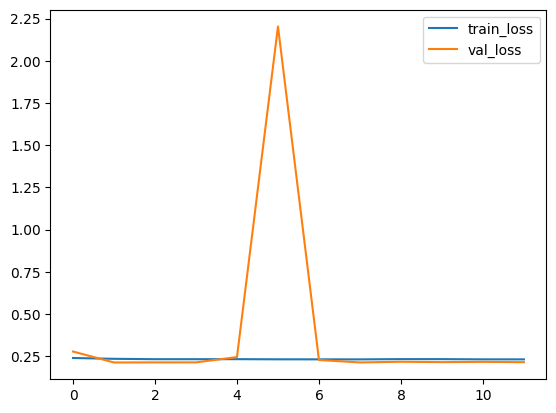

In [38]:
_ = log.plot()

Evaluation

In [39]:
#Predict Surviavl times 

surv = model.predict_surv_df(x_test)

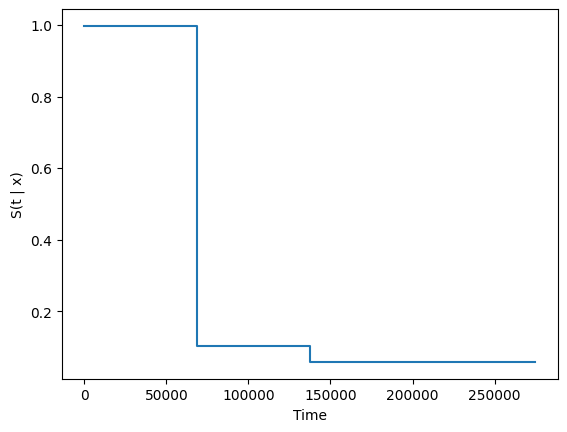

In [51]:
# Plot the Survival function against time

surv.iloc[:5, 10000].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [44]:
ev = EvalSurv(surv.iloc[:, :30000], durations_test[:30000], events_test[:30000], censor_surv='km')

C:\Users\Deepak\anaconda3\envs\Deep_learning\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [45]:
ev.concordance_td()

0.49947497424556575

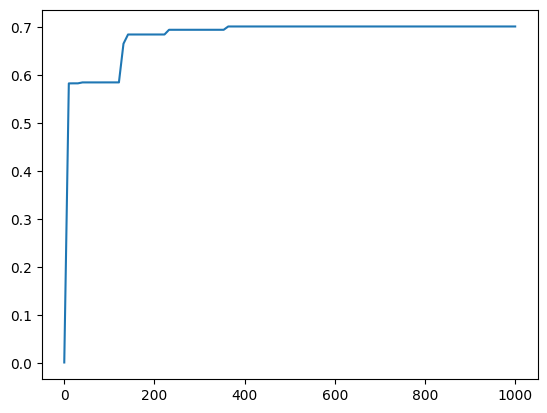

In [46]:
time_grid = np.linspace(durations_test.min(),1000, 100)
_ = ev.brier_score(time_grid).plot()

In [47]:
ev.integrated_brier_score(time_grid)

0.6815927101335166

In [48]:
ev.integrated_nbll(time_grid)

2.6088567006447776